IMPORT LIBRARIES

In [19]:
# Import Relevant Libraries
import cv2
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy import interpolate

In [20]:
def visualize_find_match(img1, img2, x1, x2, img_h=500):
    assert x1.shape == x2.shape, 'x1 and x2 should have same shape!'
    scale_factor1 = img_h/img1.shape[0]
    scale_factor2 = img_h/img2.shape[0]
    img1_resized = cv2.resize(img1, None, fx=scale_factor1, fy=scale_factor1)
    img2_resized = cv2.resize(img2, None, fx=scale_factor2, fy=scale_factor2)
    x1 = x1 * scale_factor1
    x2 = x2 * scale_factor2
    x2[:, 0] += img1_resized.shape[1]
    img = np.hstack((img1_resized, img2_resized))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    for i in range(x1.shape[0]):
        plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'b')
        plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'bo')
    plt.axis('off')
    plt.show()

In [21]:
def visualize_align_image(template, target, A, A_refined, errors=None):
    img_warped_init = warp_image(target, A, template.shape)
    img_warped_optim = warp_image(target, A_refined, template.shape)
    err_img_init = np.abs(img_warped_init - template)
    err_img_optim = np.abs(img_warped_optim - template)
    img_warped_init = np.uint8(img_warped_init)
    img_warped_optim = np.uint8(img_warped_optim)
    overlay_init = cv2.addWeighted(template, 0.5, img_warped_init, 0.5, 0)
    overlay_optim = cv2.addWeighted(template, 0.5, img_warped_optim, 0.5, 0)
    plt.subplot(241)
    plt.imshow(template, cmap='gray')
    plt.title('Template')
    plt.axis('off')
    plt.subplot(242)
    plt.imshow(img_warped_init, cmap='gray')
    plt.title('Initial warp')
    plt.axis('off')
    plt.subplot(243)
    plt.imshow(overlay_init, cmap='gray')
    plt.title('Overlay')
    plt.axis('off')
    plt.subplot(244)
    plt.imshow(err_img_init, cmap='jet')
    plt.title('Error map')
    plt.axis('off')
    plt.subplot(245)
    plt.imshow(template, cmap='gray')
    plt.title('Template')
    plt.axis('off')
    plt.subplot(246)
    plt.imshow(img_warped_optim, cmap='gray')
    plt.title('Opt. warp')
    plt.axis('off')
    plt.subplot(247)
    plt.imshow(overlay_optim, cmap='gray')
    plt.title('Overlay')
    plt.axis('off')
    plt.subplot(248)
    plt.imshow(err_img_optim, cmap='jet')
    plt.title('Error map')
    plt.axis('off')
    plt.show()

    if errors is not None:
        plt.plot(errors * 255)
        plt.xlabel('Iteration')
        plt.ylabel('Error')
        plt.show()

In [22]:
def visualize_track_multi_frames(template, img_list, A_list):
    bbox_list = []
    for A in A_list:
        boundary_t = np.hstack((np.array([[0, 0], [template.shape[1], 0], [template.shape[1], template.shape[0]],
                                        [0, template.shape[0]], [0, 0]]), np.ones((5, 1)))) @ A[:2, :].T
        bbox_list.append(boundary_t)

    plt.subplot(221)
    plt.imshow(img_list[0], cmap='gray')
    plt.plot(bbox_list[0][:, 0], bbox_list[0][:, 1], 'r')
    plt.title('Frame 1')
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(img_list[1], cmap='gray')
    plt.plot(bbox_list[1][:, 0], bbox_list[1][:, 1], 'r')
    plt.title('Frame 2')
    plt.axis('off')
    plt.subplot(223)
    plt.imshow(img_list[2], cmap='gray')
    plt.plot(bbox_list[2][:, 0], bbox_list[2][:, 1], 'r')
    plt.title('Frame 3')
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(img_list[3], cmap='gray')
    plt.plot(bbox_list[3][:, 0], bbox_list[3][:, 1], 'r')
    plt.title('Frame 4')
    plt.axis('off')
    plt.show()

In [23]:
def visualize_align_image_using_feature(img1, img2, x1, x2, A, ransac_thr, img_h=500):
    x2_t = np.hstack((x1, np.ones((x1.shape[0], 1)))) @ A.T
    errors = np.sum(np.square(x2_t[:, :2] - x2), axis=1)
    mask_inliers = errors < ransac_thr
    boundary_t = np.hstack(( np.array([[0, 0], [img1.shape[1], 0], [img1.shape[1], img1.shape[0]], [0, img1.shape[0]], [0, 0]]), np.ones((5, 1)) )) @ A[:2, :].T

    scale_factor1 = img_h/img1.shape[0]
    scale_factor2 = img_h/img2.shape[0]
    img1_resized = cv2.resize(img1, None, fx=scale_factor1, fy=scale_factor1)
    img2_resized = cv2.resize(img2, None, fx=scale_factor2, fy=scale_factor2)
    x1 = x1 * scale_factor1
    x2 = x2 * scale_factor2
    x2[:, 0] += img1_resized.shape[1]
    img = np.hstack((img1_resized, img2_resized))
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)

    boundary_t = boundary_t * scale_factor2
    boundary_t[:, 0] += img1_resized.shape[1]
    plt.plot(boundary_t[:, 0], boundary_t[:, 1], 'y')
    for i in range(x1.shape[0]):
        if mask_inliers[i]:
            plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'g')
            plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'go')
        else:
            plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'r')
            plt.plot([x1[i, 0], x2[i, 0]], [x1[i, 1], x2[i, 1]], 'ro')
    plt.axis('off')
    plt.show()

In [24]:
def find_match(img1, img2):
    # To do
    # Create a sift object.
    sift = cv2.SIFT_create()

    keypoints_1, descriptor_1 = sift.detectAndCompute(img1, None)
    keypoints_2, desciptior_2 = sift.detectAndCompute(img2, None)

    # Descriptor is the historgram item with size 128, int items for some reason.
    print("Number of keypoints 1: ", len(keypoints_1))
    print("Descriptor Shape : ", descriptor_1.shape)

    print("Number of keypoints 2 : ", len(keypoints_2))
    print("Descriptors Shape : ", desciptior_2.shape)

    # Create a Nearest Neighbour object.
    neigh = NearestNeighbors(n_neighbors = 2) # We only need two points, second point is used for ratio test.
    
    # Fit the algo to the data that we have, we fit the second image and run the algo for points in img1.
    neigh.fit(desciptior_2)
    distances, indices = neigh.kneighbors(descriptor_1)

    distance_ratio = distances[:,0]/distances[:,1]

    indices_1 = np.where(distance_ratio < 0.7)[0]
    indices_2 = indices[np.where(distance_ratio < 0.7)][:,0]

    x1 = np.array([[keypoints_1[i].pt[0], keypoints_1[i].pt[1]] for i in indices_1])
    x2 = np.array([[keypoints_2[i].pt[0], keypoints_2[i].pt[1]] for i in indices_2])


    # Initialize array for storing points.
    # x1 = np.zeros((1,2))
    # x2 = np.zeros((1,2))
    # for i, point in enumerate(descriptor_1):
    #     # Find nearest point to this point in the other image.
    #     distances, indices = neigh.kneighbors([point])
    #     # Ratio test
    #     if distances[0][0]/distances[0][1] < 0.7:
    #         kp_x ,kp_y = keypoints_1[i].pt
    #         kp2_x, kp2_y = keypoints_2[indices[0][0]].pt
    #         x1 = np.vstack((x1, np.array([kp_x, kp_y])))
    #         x2 = np.vstack((x2, np.array([kp2_x, kp2_y])))

    # Delete the first row.
    # x1 = np.delete(x1, 0, axis=0)
    # x2 = np.delete(x2, 0, axis=0)

    return x1, x2

In [25]:
def align_image_using_feature_homo(x1, x2, ransac_thr, ransac_iter):
    # To do
    # Go in a loop for number of iterations.
    max_inliner = 0
    for iter in range(ransac_iter):
        # Get index points of four points from a list of indieces.
        index_points = np.random.choice(len(x1), 4,replace=False) # Output will a numpy array.
        
        # get four random points from the data.
        # Create a 8*8 matrix of A.
        u1, v1 = x1[index_points[0]][0], x1[index_points[0]][1]
        u2, v2 = x1[index_points[1]][0], x1[index_points[1]][1]
        u3, v3 = x1[index_points[2]][0], x1[index_points[2]][1]
        u4, v4 = x1[index_points[3]][0], x1[index_points[3]][1]
        u1_, v1_ = x2[index_points[0]][0], x2[index_points[0]][1]
        u2_, v2_ = x2[index_points[1]][0], x2[index_points[1]][1]
        u3_, v3_ = x2[index_points[2]][0], x2[index_points[2]][1]
        u4_, v4_ = x2[index_points[3]][0], x2[index_points[3]][1]
        temp_A = np.array([[u1, v1, 1, 0, 0, 0, -u1*u1_, -v1*u1_],
                            [0, 0, 0, u1, v1, 1, -u1*v1_, -v1*v1_],
                            [u2, v2, 1, 0, 0, 0, -u2*u2_, -v2*u2_],
                            [0, 0, 0, u2, v2, 1, -u2*v2_, -v2*v2_],
                            [u3, v3, 1, 0, 0, 0, -u3*u3_, -v3*u3_],
                            [0, 0, 0, u3, v3, 1, -u3*v3_, -v3*v3_],
                            [u4, v4, 1, 0, 0, 0, -u4*u4_, -v4*u4_],
                            [0, 0, 0, u4, v4, 1, -u4*v4_, -v4*v4_],])
        
        # Create a b matrix.
        b = np.array([  u1_,
                        v1_,
                        u2_,
                        v2_,
                        u3_,
                        v3_,
                        u4_,
                        v4_])
        
        # Find the h matrix (x matrix)
        # x = (AT A ) -1 AT b
        x = np.matmul( np.matmul( np.linalg.inv( np.matmul(temp_A.T, temp_A)), temp_A.T) , b)

        # Find the inliners and outliners in the data.
        # Go into a loop over all items.
        x2_predicted = np.zeros(x1.shape)
        for i,point in enumerate(x1):
            x2_predicted[i][0] = (x[0]*point[0] + x[1]*point[1] + x[2])/(x[6]*point[0] + x[7]*point[1] + 1)
            x2_predicted[i][1] = (x[3]*point[0] + x[4]*point[1] + x[5])/(x[6]*point[0] + x[7]*point[1] + 1)

        # Find distance between the two points in the array.
        error = np.sqrt(np.square(x2[:,0] - x2_predicted[:,0]) + np.square(x2[:,1] - x2_predicted[:,1]))
        inliners = len(np.where(error < ransac_thr))
        if inliners > max_inliner:
            A = temp_A
            A = np.array([[x[0], x[1], x[2]],
                          [x[3], x[4], x[5]],
                          [x[6], x[7], 1]])
            x1_ret = x1[np.where(error < ransac_thr)]
            x2_ret = x2[np.where(error < ransac_thr)]
            max_inliner = inliners
            x1_outliners = x1[np.where(error > ransac_thr)]
            x2_outliners = x2[np.where(error > ransac_thr)]
    # This return is wrong A is supposed to be the 3*3 matrix.
    return A, x1_ret, x2_ret, x1_outliners, x2_outliners

In [57]:
def align_image_using_feature(x1, x2, ransac_thr, ransac_iter):
    # To do
    # Go in a loop for number of iterations.
    np.random.seed(32)
    max_inliner = 0
    for iter in range(ransac_iter):
        # Get index points of four points from a list of indieces. We need three correspondance points for a Affine transformation.
        index_points = np.random.choice(len(x1), 3,replace=False) # Output will a numpy array.
        
        # get three random points from the data.
        # Create a 8*8 matrix of A.
        u1, v1 = x1[index_points[0]][0], x1[index_points[0]][1]
        u2, v2 = x1[index_points[1]][0], x1[index_points[1]][1]
        u3, v3 = x1[index_points[2]][0], x1[index_points[2]][1]
        u1_, v1_ = x2[index_points[0]][0], x2[index_points[0]][1]
        u2_, v2_ = x2[index_points[1]][0], x2[index_points[1]][1]
        u3_, v3_ = x2[index_points[2]][0], x2[index_points[2]][1]
        M = np.array([[u1, v1, 1, 0, 0, 0],
                    [0, 0, 0, u1, v1, 1],
                    [u2, v2, 1, 0, 0, 0],
                    [0, 0, 0, u2, v2, 1],
                    [u3, v3, 1, 0, 0, 0],
                    [0, 0, 0, u3, v3, 1]])
        
        # Create a b matrix.
        b = np.array([  u1_,
                        v1_,
                        u2_,
                        v2_,
                        u3_,
                        v3_])
        
        # Find the affine transform matrix (x matrix)
        x = np.matmul( np.matmul( np.linalg.inv( np.matmul(M.T, M)), M.T) , b)
        # Make the affine matrix from x.
        temp_A = np.array([[x[0], x[1], x[2]],
                      [x[3], x[4], x[5]],
                      [0, 0, 1]])
        # Find the predicted x2 points. 
        x2_t = np.hstack((x1, np.ones((x1.shape[0], 1)))) @ temp_A.T    # Transpose of equation is done.
        # Find the error in transformation.
        errors = np.sum(np.square(x2_t[:, :2] - x2), axis=1)
        inliners = np.sum(errors < ransac_thr)

        # Apply thresholding.
        if inliners > max_inliner:
            # This is better result.
            A = temp_A    # Set the return affine transfrom as this one
            max_inliner = inliners   # Set new value for the max_inliners.
    print("Input keypoints to Ransac were : ", len(x2))
    print("Number of Inliners after Ransac : ", max_inliner)
    return A

In [58]:
def warp_image(img, A, output_size):
    # To do
    print("Shape of input image is : ", img.shape )
    print("Output size is : ", output_size)
    img_warped = np.zeros(output_size)
    print("Shape of Img warped : ", img_warped.shape)
    # A is out mapper of size 3*3
    # Go to every pixel of img.
    # for row in range(len(img)):
    #     for col in range(len(img[0])):
    #         # Mapped point
    #         out_point = np.matmul(A, np.array([[row],[col],[1]]))
    #         row_mapped, col_mapped = out_point[0][0], out_point[1][0]
    #         print("Mapped row and col : ",row_mapped, col_mapped)
    #         if (int(col_mapped) < img_warped.shape[1]) and (int(row_mapped) < img_warped.shape[0]):
    #             img_warped[int(row_mapped)][int(col_mapped)] = img[row][col]    
    return img_warped

Number of keypoints 1:  423
Descriptor Shape :  (423, 128)
Number of keypoints 2 :  1765
Descriptors Shape :  (1765, 128)


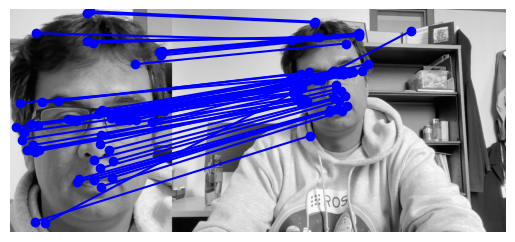

No of Keypoints after find match :  53
Input keypoints to Ransac were :  53
Number of Inliners after Ransac :  36


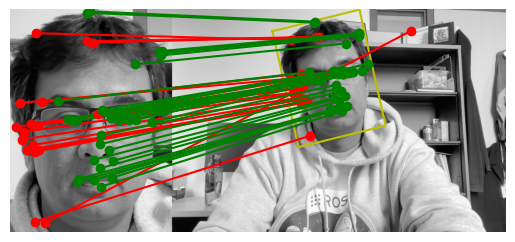

In [59]:
if __name__ == '__main__':
    template = cv2.imread('./JS_template.jpg', 0)  # read as grey scale image
    target_list = []
    for i in range(4):
        target = cv2.imread('./JS_target{}.jpg'.format(i+1), 0)  # read as grey scale image
        target_list.append(target)

    x1, x2 = find_match(template, target_list[0])
    visualize_find_match(template, target_list[0], x1, x2)

    ransac_thr = 100
    ransac_iter = 500
    print("No of Keypoints after find match : ", len(x1))
    # A, x1_ret, x2_ret, x1_outliners, x2_outliners = align_image_using_feature(x1, x2, ransac_thr, ransac_iter)
    A = align_image_using_feature(x1, x2, ransac_thr, ransac_iter)
    visualize_align_image_using_feature(template, target_list[0], x1, x2, A, ransac_thr, img_h=500)

    # visualize_find_match(template, target_list[0], x1_ret, x2_ret)
    # visualize_find_match(template, target_list[0], x1_outliners, x2_outliners)
    # img_warped = warp_image(target_list[0], A, template.shape)
    # plt.imshow(img_warped, cmap='gray', vmin=0, vmax=255)
    # plt.axis('off')
    # plt.show()

    # A_refined, errors = align_image(template, target_list[0], A)
    # visualize_align_image(template, target_list[0], A, A_refined, errors)

    # A_list = track_multi_frames(template, target_list)
    # visualize_track_multi_frames(template, target_list, A_list)

In [16]:
def align_image(template, target, A):
    # To do
    return A_refined

In [1]:
def track_multi_frames(template, img_list):
    # To do
    return A_list